<a href="https://colab.research.google.com/github/cabamarcos/Vision_Artificial_P1/blob/main/Vision_Artificial_P1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
%matplotlib inline

##Visión Artificial
##Práctica 2: CNNs para clasificación de imágenes
Iván González Díaz y Fernando Díaz de María

## 1.- Introducción

En esta práctica vamos a implementar un sistema de diagnóstico de lesiones cutáneas a partir de imágenes dermatoscópicas.

Antes de comenzar la práctica, describiremos brevemente la base de datos que utilizaremos y el problema que pretendemos abordar.

Nuestro objetivo es implementar una CNN que proporcione un diagnóstico automático de lesiones cutáneas a partir de imágenes dermatoscópicas. La dermatoscopia es una técnica no invasiva que permite evaluar estructuras que no son visibles a simple vista y que correlacionan específicamente con las propiedades histológicas de las lesiones. La identificación de patrones visuales específicos relacionados con la distribución del color o las estructuras dermatoscópicas puede ayudar a los dermatólogos a decidir sobre la malignidad de una lesión pigmentada. El uso de esta técnica proporciona una gran ayuda a los expertos para apoyar su diagnóstico. Sin embargo, la complejidad de su análisis limita su aplicación a clínicos o dermatólogos experimentados.

En nuestro escenario, consideraremos 3 clases de lesiones:

- Melanoma maligno: El melanoma, también conocido como melanoma maligno, es el tipo más común de cáncer y surge de células pigmentadas conocidas como melanocitos. Los melanomas suelen aparecer en la piel y rara vez en otros lugares como la boca, los intestinos o el ojo.

- Queratosis seborreica: es un tumor no canceroso (benigno) de la piel que se origina en las células de la capa externa de la piel (queranocitos), por lo que es una lesión no melanocítica.

- Lunar (nevus) benigno: tumor benigno de la piel originado por melanocitos (es melanocítico).

La figura 1 muestra un ejemplo visual de las 3 lesiones consideradas:

![Imagen de ISIC](https://www.tsc.uc3m.es/~igonzalez/images/ISIC.jpg)

El conjunto de datos se ha obtenido del archivo 'Internatial Skin Imaging Collaboration' (ISIC). Contiene 2750 imágenes divididas en 3 conjuntos:
- Conjunto de entrenamiento: 2000 imágenes
- Conjunto de validación: 150 imágenes
- Conjunto de prueba 600 imágenes

Para cada caso clínico se dispone de dos imágenes:
- La imagen dermatoscópica de la lesión (en la carpeta 'images').
- Una máscara binaria con la segmentación entre lesión (lunar) y piel (en la carpeta 'masks').

Además, existe un archivo csv para cada conjunto de datos (entrenamiento, validación y prueba) en el que cada fila se corresponde con un caso clínico, definido con dos campos separados por comas:
- el id numérico de la lesión: que permite definir las rutas a los ficheros que contienen la imagen y la máscara.
- la etiqueta de la lesión: disponible sólo para el entrenamiento y la validación, siendo un número entero entre 0 y 2: 0: nevus benigno, 1: melanoma maligno, 2: queratosis seborreica. En el caso del conjunto de test, las etiquetas no están disponibles (su valor es -1).

Los estudiantes podrán utilizar los conjuntos de entrenamiento y validación para implementar sus soluciones. Esta práctica proporciona una guía para construir un sistema básico. Para ello, aprenderemos dos procedimientos fundamentales:

1) Procesar nuestra propia base de datos con pytorch
2) Diseñar una CNN  que procese imágenes y proporcione un diagnóstico


## 2.- Nuestra base de datos en pytorch

Ahora vamos a estudiar cómo podemos cargar y procesar nuestra base de datos personalizado en pytorch. Para ello, vamos a utilizar la librería ``scikit-image`` para la lectura de imágenes y ``pandas`` para la lectura de ficheros csv.

In [6]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform, util
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from PIL import Image
import pdb
import random
import numpy.random as npr

random.seed(42)
npr.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.enabled = False

# Ignore warnings
import warnings
#warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Lo primero que tenemos que hacer es descargar y descomprimir el conjunto de datos en una carpeta local.




In [4]:
#ONLY TO USE GOOGLE COLAB. Run this code only the first time you run this notebook and, then, comment these lines
from shutil import copyfile
from google.colab import drive
import os, sys
drive.mount('/content/drive')
copyfile('/content/drive/My Drive/VisionArtificial/db1.zip', './db1.zip') #Copy db files to our working folder
copyfile('/content/drive/My Drive/VisionArtificial/db2.zip', './db2.zip')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'./db2.zip'

In [7]:
#NOTE: Run this only once in the machine where you want to run your code and, then, comment these lines
import zipfile
zipPath='./db1.zip' #path of the 1st zip file
dataFolder='./data' #We extract files to the current folder
with zipfile.ZipFile(zipPath, 'r') as zip_ref:
    zip_ref.extractall(dataFolder)

zipPath='./db2.zip' #path of the 2nd zip file
dataFolder='./data' # We extract files to the current folder
with zipfile.ZipFile(zipPath, 'r') as zip_ref:
    zip_ref.extractall(dataFolder)

Ahora vamos a leer el archivo y mostrar los datos de la imagen 65. La estructura del fichero csv es una fila por imagen de la base de datos, y dos campos:
    - ID de la imagen (una secuencia de 4 dígitos, añadiendo ceros a la izquierda si es necesario)
    - Etiqueta: 0 nevus benigno, 1 melanoma, 2 queratosis seborreica




In [8]:
db = pd.read_csv('data/dermoscopyDBtrain.csv', header=0, dtype={'id': str, 'label': int})

#We show inform
n = 65
img_id = db.id[65]
label = db.label[65]

print(f'Image ID: {img_id}')
print(f'Label: {label}')

Image ID: 0066
Label: 0


Ahora, vamos a crear una función simple para mostrar una imagen.


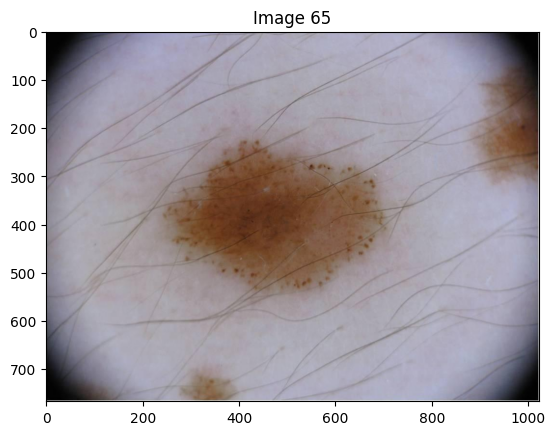

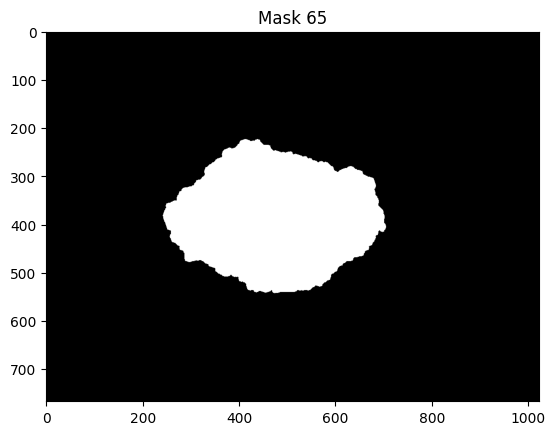

In [9]:
def imshow(image, title_str):
    if len(image.shape)>2:
        plt.imshow(image)
    else:
        plt.imshow(image,cmap='gray')
    plt.title(title_str)

plt.figure()
imshow(io.imread(os.path.join('data/images/', img_id + '.jpg' )),'Image %d'%n)
plt.figure()
imshow(io.imread(os.path.join('data/masks/', img_id + '.png')),'Mask %d'%n)

plt.show()

### Class Dataset

La clase `` torch.utils.data.Dataset`` es una clase abstracta que representa una base de datos.

Para crear nuestro dataset personalizado en pytorch debemos heredar de esta clase y sobrescribir los siguientes métodos:

- `` __len__`` para que `` len (dataset) `` devuelva el tamaño del dataset.
- `` __getitem__`` para soportar la indexación `` dataset [i] `` cuando se refiera a la muestra $i$

Vamos a crear las bases de datos de entrenamiento y validación de nuestro problema de diagnóstico. Leeremos el csv en el método de inicialización `` __init__`` pero dejaremos la lectura explícita de las imágenes para el método
`` __getitem__``. Este enfoque es más eficiente porque todas las imágenes no se cargan en memoria al principio, sino que se leen individualmente cuando es necesario.

Nuestra base de datos será un diccionario `` {'image': image, 'mask': mask, 'label': label} ``. También puede tomar un argumento opcional `` transform '' para que podamos añadir técnicas de preprocesamiento y "data augmentation".



In [10]:
class DermoscopyDataset(Dataset):
    """Dermoscopy dataset."""

    def __init__(self, csv_file, root_dir, transform=None, maxSize=0):
        """
        Args:
            csv_file (string): Path al fichero csv con las anotaciones.
            root_dir (string): Directorio raíz donde encontraremos las carpetas 'images' y 'masks' .
            transform (callable, optional): Transformaciones opcionales a realizar sobre las imágenes.
        """
        self.dataset = pd.read_csv(csv_file,header=0,dtype={'id': str, 'label': int})

        if maxSize>0:
            newDatasetSize=maxSize #maxSize muestras
            idx=np.random.RandomState(seed=42).permutation(range(len(self.dataset)))
            reduced_dataset=self.dataset.iloc[idx[0:newDatasetSize]]
            self.dataset=reduced_dataset.reset_index(drop=True)

        self.root_dir = root_dir
        self.img_dir = os.path.join(root_dir,'images')
        self.mask_dir = os.path.join(root_dir,'masks')
        self.transform = transform
        self.classes = ['nevus', 'melanoma', 'keratosis']

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        #Leemos la imagen
        img_name = os.path.join(self.img_dir,self.dataset.id[idx] + '.jpg')
        image = io.imread(img_name)
        #Leemos la máscara
        mask_name = os.path.join(self.mask_dir,self.dataset.id[idx] + '.png')
        mask = io.imread(mask_name)

        sample = {'image': image, 'mask': mask, 'label':  self.dataset.label[idx].astype(dtype=int)}
        if self.transform:
            sample = self.transform(sample)
        return sample

Ahora instanciamos la clase para iterar sobre algunas muestras y ver lo que generamos.


0 (767, 1022, 3) 0
1 (767, 1022, 3) 0
2 (767, 1022, 3) 1
3 (767, 1022, 3) 0


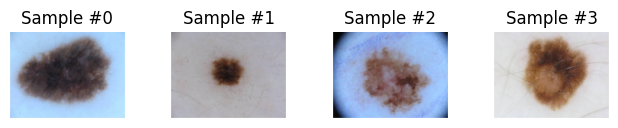

In [11]:
train_dataset = DermoscopyDataset(csv_file='data/dermoscopyDBtrain.csv',
                                    root_dir='data')

fig = plt.figure()

for i in range(len(train_dataset)):
    sample = train_dataset[i]
    print(i, sample['image'].shape, sample['label'])

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title(f"Sample #{i}")
    ax.axis('off')
    plt.imshow(sample['image'])

    if i == 3:
        plt.show()
        break

**IMPORTANTE**

El parámetro opcional ``maxSize`` en el "constructor" nos permite submuestrear el número de imágenes y, en consecuencia, reducir el tamaño del conjunto de datos. Si no se incluye o maxSize=0, el conjunto de datos incluirá todas las imágenes. Este parámetro es útil para entrenar modelos sobre conjuntos de datos más pequeños durante las fases de validación y selección de hiperparámetros. Trabajar con menos imágenes reduce el tiempo de entrenamiento a costa de obtener resultados que pueden desviarse de los obtenidos con la base de datos completa. Por supuesto, cuanto mayor sea el conjunto de datos de entrenamiento, más estables serán los resultados, pero mayor será el tiempo de entrenamiento. De ahí que dependa de los estudiantes el uso de este parámetro.

### Data pre-processing and Augmentation: Transforms
----------

In the previously shown examples we can see that the size of the images is not the same. This would prevent to train a red convolutional neuronal, as the vast majority require fixed-size inputs. Furthermore, the image is not always adjusted to the lesion, and indeed, in some examples lesions are very small compared to the size of the image. It would then be desirable to adjust the input images so that the lesion covers almost the entire image.

To do this, we are going to create some preprocessing code, focusing on 5 transformations:

- ``CropByMask``: to crop the image using the lesion mask
- ``Rescale``: to scale the image
- ``RandomCrop``: to crop the image randomly, it allows us to augment the data samples with random crops
- ``CenterCrop``: to perform a central crop of the image with the indicated size (useful in test)
- ``ToTensor``: to convert numpy matrices into torch tensors (rearranging the axes).

We will define them as callable classes instead of simple functions, as we will not need to pass the transform  parameters every time we call a method. To do this, we only have to implement the `` __call__`` method and, if necessary, the `` __init__`` method.
Then we can use a transformation with the following code:

::

    tsfm = Transform(params)
    transformed_sample = tsfm(sample)


In [12]:
class CropByMask(object):
    """Crop the image using the lesion mask.

    Args:
        border (tuple or int): Border surrounding the mask. We dilate the mask as the skin surrounding
        the lesion is important for dermatologists.
        If it is a tuple, then it is (bordery,borderx)
    """

    def __init__(self, border):
        assert isinstance(border, (int, tuple))
        if isinstance(border, int):
            self.border = (border,border)
        else:
            self.border = border

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'],sample['label']
        h, w = image.shape[:2]
        #Compute the coordinates of the bounding box that contains the mask
        sidx=np.nonzero(mask)
        minx=np.maximum(sidx[1].min()-self.border[1],0)
        maxx=np.minimum(sidx[1].max()+1+self.border[1],w)
        miny=np.maximum(sidx[0].min()-self.border[0],0)
        maxy=np.minimum(sidx[0].max()+1+self.border[1],h)
        #Crop the image
        image=image[miny:maxy,minx:maxx,...]
        mask=mask[miny:maxy,minx:maxx]

        return {'image': image, 'mask': mask, 'label' : label}

class Rescale(object):
    """Re-scale image to a predefined size.

    Args:
        output_size (tuple or int): The desired size. If it is a tuple, output is the output_size.
        If it is an int, the smallest dimension will be the output_size
            and we will keep fixed the original aspect ratio.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'],sample['label']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))
        msk = transform.resize(mask, (new_h, new_w))

        return {'image': img, 'mask': msk, 'label' : label}

class RandomCrop(object):
    """Randomly crop the image.

    Args:
        output_size (tuple or int): Crop size. If  int, square crop

    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'],sample['label']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        if h>new_h:
            top = np.random.randint(0, h - new_h)
        else:
            top=0

        if w>new_w:
            left = np.random.randint(0, w - new_w)
        else:
            left = 0

        image = image[top: top + new_h,
                     left: left + new_w]

        mask = mask[top: top + new_h,
                      left: left + new_w]


        return {'image': image, 'mask': mask, 'label': label}

class CenterCrop(object):
    """Crop the central area of the image

    Args:
        output_size (tupla or int): Crop size. If int, square crop

    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'],sample['label']
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        rem_h = h - new_h
        rem_w = w - new_w

        if h>new_h:
            top = int(rem_h/2)
        else:
            top=0

        if w>new_w:
            left = int(rem_w/2)
        else:
            left = 0

        image = image[top: top + new_h,
                     left: left + new_w]

        mask = mask[top: top + new_h,
                      left: left + new_w]


        return {'image': image, 'mask': mask, 'label': label}


class ToTensor(object):
    """Convert ndarrays into pytorch tensors."""

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'],sample['label']

        # Cambiamos los ejes
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        image = torch.from_numpy(image)
        # A la máscara le añadimos una dim fake al principio
        mask = torch.from_numpy(mask)
        mask = mask.unsqueeze(0)
        label=torch.tensor(label,dtype=torch.long)

        return {'image':image,
                'mask':mask,
                'label':label}

class Normalize(object):
    """Normalize data by subtracting means and dividing by standard deviations.

    Args:
        mean_vec: Vector with means.
        std_vec: Vector with standard deviations.
    """

    def __init__(self, mean,std):

        assert len(mean)==len(std),'Length of mean and std vectors is not the same'
        self.mean = np.array(mean)
        self.std = np.array(std)

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'],sample['label']
        c, h, w = image.shape
        assert c==len(self.mean), 'Length of mean and image is not the same'
        dtype = image.dtype
        mean = torch.as_tensor(self.mean, dtype=dtype, device=image.device)
        std = torch.as_tensor(self.std, dtype=dtype, device=image.device)
        image.sub_(mean[:, None, None]).div_(std[:, None, None])


        return {'image': image, 'mask': mask, 'label' : label}

### Ejercicio:

Utiliza el siguiente código para aplicar las transformaciones anteriores y experimenta con los valores de los parámetros para estudiar su influencia. Lee la documentación al principio de cada clase para entender la sintaxis de los parámetros de entrada.



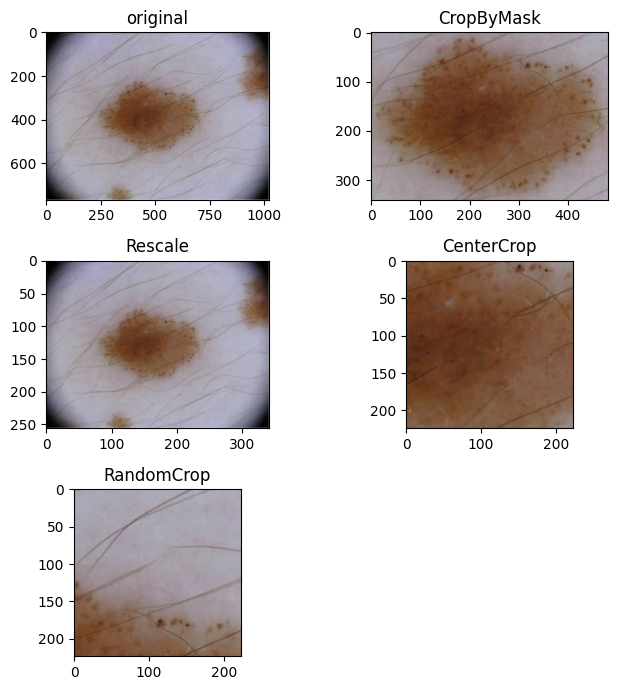

In [13]:
### Modify this code to make your experiments....
cmask = CropByMask(10)
scale = Rescale(256)
rcrop = RandomCrop(224)
ccrop = CenterCrop(224)

# Apply each of the above transforms on sample.
fig = plt.figure(figsize=(7,7))
sample = train_dataset[65]
ax = plt.subplot(3,2, 1)
plt.tight_layout()
ax.set_title('original')
plt.imshow(sample['image'])

for i, tsfrm in enumerate([cmask, scale, ccrop, rcrop]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(3, 2, i+2)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    plt.imshow(transformed_sample['image'])

plt.show()

#### La librería torchvision.transforms

La librería torchvision.trasforms proporciona muchos métodos útiles para "data augmentation". Estas transformaciones pueden aplicarse tanto a torch.tensors como a imágenes. Sin embargo, torchvision utiliza la librería PIL para leer y procesar imágenes, en contraste con la representación matricial de imágenes utilizada en la librería scikit-image (la que hemos utilizado en los métodos anteriores). Además, hay que tener en cuenta que algunas de las transformaciones afectan tanto a las imágenes de entrada como a las máscaras. Por lo tanto, para utilizar torchvision.trasforms necesitamos implementar un pipeline como este:

1) En primer lugar, convertimos las imágenes matriciales en imágenes PIL.
2) Aplicamos la transformación a PILImages
3) Convertimo las PILImages en matrices

Y aplicamos a las imágenes de entrada y, si es necesario, a las máscaras binarias de piel-lesión. La siguiente clase ``TVCenterCrop`` implementa la misma funcionalidad que la anterior ``CenterCrop``, pero utilizando el método correspondiente en torchvision. Por lo tanto, es un ejemplo útil si planea hacer uso de las transformaciones de torchvision.


In [14]:
class TVCenterCrop(object):
    """Crop the central area of the image. Example using the method in torchvision. Requires to
    internally convert from skimage (numpy array) to PIL Image

    Args:
        output_size (tupla or int): Crop size. If int, square crop

    """

    def __init__(self, size):
        self.CC=transforms.CenterCrop(size)

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'],sample['label']
        pil_image=Image.fromarray(util.img_as_ubyte(image))
        pil_image=self.CC(pil_image)
        image=util.img_as_float(np.asarray(pil_image))

        pil_mask=Image.fromarray(util.img_as_ubyte(mask))
        pil_mask=self.CC(pil_mask)
        mask=util.img_as_float(np.asarray(pil_mask))

        return {'image': image, 'mask': mask, 'label': label}

Veamos los resultados

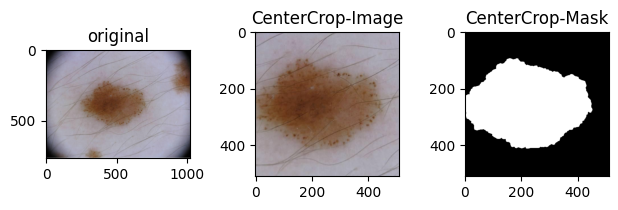

In [15]:
# Apply each of the above transforms on sample.
fig = plt.figure()
sample = train_dataset[65]
ax = plt.subplot(1,3, 1)
plt.tight_layout()
ax.set_title('original')
plt.imshow(sample['image'])

tvcc=TVCenterCrop(512)

transformed_sample = tvcc(sample)
ax = plt.subplot(1, 3, 2)
plt.tight_layout()
ax.set_title('CenterCrop-Image')
plt.imshow(transformed_sample['image'])
ax = plt.subplot(1, 3, 3)
plt.tight_layout()
ax.set_title('CenterCrop-Mask')
plt.imshow(transformed_sample['mask'],cmap='gray')

plt.show()

### Ejercicio
Implemente otras transformaciones utilizando el paquete torchvision. Tome TVCenterCrop como guía.


In [16]:
### Put your code here....



### Combinación de transformaciones

Ahora vamos a aplicar diferentes transformaciones a nuestras imágenes.

Reescalaremos las imágenes para que su dimensión más pequeña sea 224 y luego haremos recortes aleatorios de tamaño 224. Para componer las transformaciones Rescale y RandomCrop podemos utilizar torchvision.transforms.Compose.


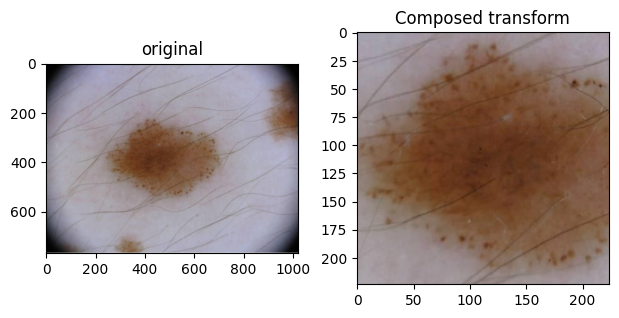

In [17]:
composed = transforms.Compose([CropByMask(15), Rescale(224), RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = train_dataset[65]
ax = plt.subplot(1,2, 1)
plt.tight_layout()
ax.set_title('original')
plt.imshow(sample['image'])

transformed_sample = composed(sample)
ax = plt.subplot(1, 2, 2)
plt.tight_layout()
ax.set_title('Composed transform')
plt.imshow(transformed_sample['image'])

plt.show()

### Ejercicio:

Utiliza el código anterior para probar distintas combinaciones de transformaciones

In [18]:
### Put your code here....

### Ejercicio:

Las técnicas de aumento de datos son útiles siempre que modelen transformaciones aleatorias que pueden ocurrir en el mundo real. Por lo tanto, la elección de las técnicas de aumento de datos que deben aplicarse depende del problema y puede variar de un conjunto de un problema a otro. Echa un vistazo a las imágenes de la base de datos e intente averiguar qué transformaciones son adecuadas para este problema. Imagine cómo toma un dermatólogo una imagen dermatoscópica y qué factores pueden diferir de una captura a otra. ¡¡¡¡Tus resultados en el reto dependerán en gran medida de tu diseño!!!!

In [19]:
### Put your code here....



Datasets y Dataloaders
-----------------------------

Ahora podemos juntarlo todo para crear bases de datos de entrenamiento y test con las transformaciones correspondientes. En resumen, cada vez que leamos una  una imagen de la basae de datos (durante el entrenamiento):

    - Leeremos la imagen y la máscara
    - Aplicaremos las transformaciones y recortaremos la imagen utilizando un bounding box calculado a partir de la máscara.
    - Como la operación final de recorte es aleatoria, aumentamos los datos durante el muestreo.


In [20]:
#Pixel means and stds expected by models in torchvision
pixel_mean=[0.485, 0.456, 0.406]
pixel_std=[0.229, 0.224, 0.225]

#Train Dataset
train_dataset = DermoscopyDataset(csv_file='data/dermoscopyDBtrain.csv',
                                    root_dir='data',
                                    maxSize=500, ###IMPORTANT: maxSize=500 to speed-up the training process
                                                 ### Set to 0 for training your optimal model
                                    transform=transforms.Compose([
                                    CropByMask(15),
                                    Rescale(224),
                                    RandomCrop(224),
                                    ToTensor(),
                                    Normalize(mean=pixel_mean,
                                    std=pixel_std)
                                    ]))
#Val dataset
val_dataset = DermoscopyDataset(csv_file='data/dermoscopyDBval.csv',
                                    root_dir='data',
                                    transform=transforms.Compose([
                                    CropByMask(15),
                                    Rescale(224),
                                    CenterCrop(224),
                                    ToTensor(),
                                    Normalize(mean=pixel_mean,
                                    std=pixel_std)
                                    ]))

#Test dataset
test_dataset = DermoscopyDataset(csv_file='data/dermoscopyDBtest.csv',
                                    root_dir='data',
                                    transform=transforms.Compose([
                                    CropByMask(15),
                                    Rescale(224),
                                    CenterCrop(224),
                                    ToTensor(),
                                    Normalize(mean=pixel_mean,
                                    std=pixel_std)
                                    ]))

for i in range(len(train_dataset)):
    sample = train_dataset[i]

    print(i, sample['image'].size(), sample['label'])

    if i == 3:
        break

0 torch.Size([3, 224, 224]) tensor(2)
1 torch.Size([3, 224, 224]) tensor(1)
2 torch.Size([3, 224, 224]) tensor(0)
3 torch.Size([3, 224, 224]) tensor(0)


Finalmente, tenemos que crear un dataloader que permita:

- Generar batches para alimentar la red durante el entrenamiento
- Barajar (shuffle) los datos
- Cargar los datos en paralelo utilizando múltiples núcleos.


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


0 torch.Size([64, 3, 224, 224]) tensor([0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 2])


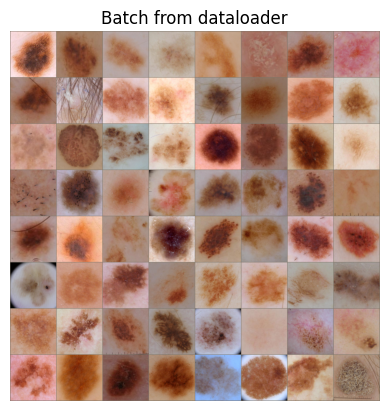

1 torch.Size([64, 3, 224, 224]) tensor([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 2,
        0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 1, 1, 2, 0, 0, 0])


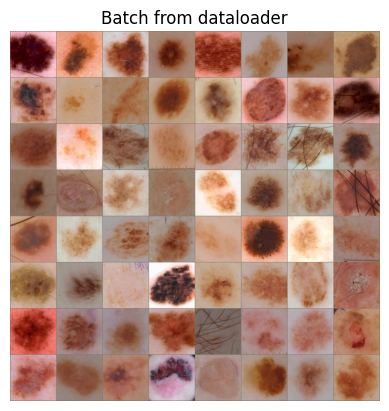

2 torch.Size([64, 3, 224, 224]) tensor([0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 2, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 2,
        0, 0, 0, 0, 0, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0])


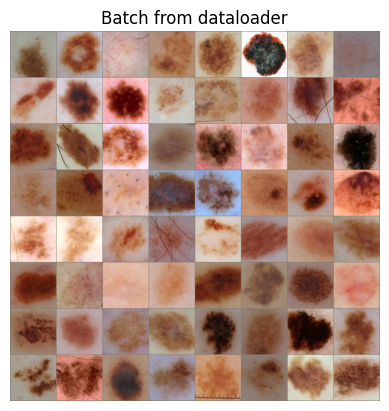

3 torch.Size([64, 3, 224, 224]) tensor([0, 2, 1, 1, 0, 0, 0, 2, 0, 0, 0, 2, 1, 0, 1, 0, 0, 0, 2, 1, 0, 1, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 2, 1, 0, 0, 1, 0, 2, 0, 0, 2, 0, 2,
        0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 2, 0])


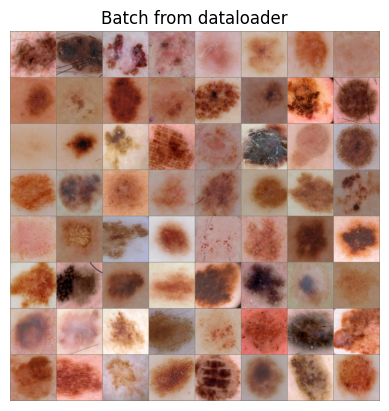

In [21]:
#Specify training dataset, with a batch size of 8, shuffle the samples, and parallelize with 3 workers
#IMPORTANT!!!!! If you plan to run this in a Windows machine, set num_workers=0. Pytorch has a bug on windows
train_dataloader = DataLoader(train_dataset, batch_size=64,
                        shuffle=True, num_workers=3)
#Validation dataset => No shuffle
val_dataloader = DataLoader(val_dataset, batch_size=256,
                        shuffle=False, num_workers=3)

#Test Dataset => => No shuffle
test_dataloader = DataLoader(test_dataset, batch_size=256,
                        shuffle=False, num_workers=3)


# Auxiliary function to visualize a batch
def show_batch(sample_batched):
    """Mostramos las lesiones de un batch."""
    images_batch, labels_batch = \
            sample_batched['image'], sample_batched['label']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    #Generamos el grid
    grid = utils.make_grid(images_batch)
    #Lo pasamos a numpy y lo desnormalizamos
    grid=grid.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    grid = std * grid + mean
    grid = np.clip(grid, 0, 1)
    plt.imshow(grid)
    plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(train_dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['label'])
    plt.figure()
    show_batch(sample_batched)
    plt.axis('off')
    plt.ioff()
    plt.show()

    #We show the data of the 3rd batch and stop.
    if i_batch == 3:
        break

## 3.- Diseño y entrenamiento de una red de diagnóstico
En esta segunda parte de la práctica diseñamos una red de diagnóstico desde cero. Con ese fin, a continuación proporcionamos una definición de una red que es muy similar a LeNet-5, la cual tiene como objetivo clasificar imágenes de entrada de tamaño 32x32 px que contienen dígitos (conjunto de datos MNIST con 10 clases). Sin embargo, en este caso, no estamos obligados a trabajar con imágenes tan pequeñas y, de hecho, se recomienda encarecidamente utilizar tamaños más grandes (por ejemplo, 224x224 px, ya que representa el tamaño estándar para la mayoría de las redes conocidas entrenadas en Imagenet).

En la siguiente celda proporcionamos el esqueleto de una red llamada CustomNet, con los métodos necesarios: __init__ (constructor) y forward (el método forward procesa una imagen y proporciona un vector con las puntuaciones de las 10 clases consideradas en el problema de clasificación de dígitos).


In [22]:
#Example network
class CustomNet(nn.Module):
    def __init__(self):
        # In the constructor we will specify those processing blocks which require learnable parameters
        # We just define them to ensure persistence during training, although they will remain disconnected
        # until we define a processing pipeline in forward method.
        super(CustomNet, self).__init__()

        #2D convolution with 3 input channels, 16 output channels, and 5x5 filters
        self.conv1 = nn.Conv2d(3, 6, 5)
        # Maxpooling with kernel 2x2
        self.pool = nn.MaxPool2d(2, 2)
        # 2D convolution with 16 input channels, 64 output channels, and 5x5 filters
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Fully-connected layer which expects an input with 16 channels and a spatial dimension of 5x5 (before flatenning)
        # and produces 120 channels at the output
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # Fully-connected layer which expects an input of 120 channels and produces an output of 84 channels
        self.fc2 = nn.Linear(120, 84)
        # Fully-connected layer which expects an input of 84 channels and produces an output with 10 classes
        self.fc3 = nn.Linear(84, 10)

    #In forward method we connect layers and define the processing pipeline of the network
    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #Flatten method vectorizes the spatial output of size hxwxchannels into a vector of length h*w*channels
        #by setting the parameter to 1, we start to flatten in dim=1 and do not vectorize the dimension representing
        #the images in the batch
        # x = x.flatten(1)
        #x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        #x = self.fc3(x)

        return x

#### Ejercicio:

Modifique la red anterior y defina una CNN que procese un batch de imágenes (por ejemplo, de tamaño 224x224) y calcule sus salidas con scores para las 3 clases que consideramos en nuestro problema (nevus, melanoma y queratosis).

**IMPORTANTE**: La estructura de la red debe ser coherente para transformar el tensor de entrada Nx3x224x224 (N el número de imágenes por batch, 3 los canales RGB y 224x224 las dimensiones espaciales) en el tensor con los scores de cada clase, con tamaño Nx3 (N el número de imágenes por batch y 3 las clases del problema). Para hacerlo, debe ajustar la arquitectura del ejemplo anterior, incluyendo el número de capas, el stride de cada una, etc. para que transforme el tensor de entrada en el vector final deseado. Como ayuda, se proporciona el siguiente código que le permite ejecutar la red sobre un batch de imágenes y ver cuál es la forma de la salida.

In [23]:
customNet = CustomNet() #we initialize the network
customNet.to(device) #copy the network to the device (gpu)
#Sample a batch of data and get images and labels
data=next(iter(train_dataloader))
inputs = data['image'].to(device).float()
labels = data['label'].to(device)

batchSize = labels.shape
print('Size of tensor containing a batch of images is {}'.format(inputs.shape))

#Lo pasamos por la red
with torch.set_grad_enabled(False):
    outputs = customNet(inputs)
    print('Size of the output tensor is {}'.format(outputs.shape))



Size of tensor containing a batch of images is torch.Size([64, 3, 224, 224])
Size of the output tensor is torch.Size([64, 16, 53, 53])


**Sugerencia**: Comience comentando todas las líneas en el método forward excepto la primera capa convolucional, ejecute la celda anterior y verá la forma de la salida de esa capa. Vaya descomentando capa por capa para ver los tamaños de salida y decidir cuántas capas convolucionales pueden ser adecuadas,etc.

## 4.- Entrenamiento y evaluación de nuestra CNN

En la tercera parte de la práctica vamos a construir un primer sistema automático para el diagnóstico de lesiones cutáneas basado en la red que hemos creado en la sección anterior. Para entrenar y evaluar la red, necesitamos definir varios elementos, como la métrica de rendimiento, la función de pérdida, el optimizador o la estrategia de tasa de aprendizaje. En las siguientes secciones configuraremos estos elementos.

### Medida del rendimiento
Comenzaremos definiendo la métrica que utilizaremos para evaluar nuestra red. En particular, y siguiendo las instrucciones de los organizadores del desafío ISIC original, utilizaremos el área bajo la curva ROC o AUC (https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve).

El AUC es una métrica que evita establecer un umbral específico para realizar detecciones y se aplica sobre las salidas suaves de un clasificador binario. Al modificar el valor del umbral, podemos construir una curva ROC estableciendo la Tasa de Falsos Positivos (FPR) en el eje y y la Tasa de Verdaderos Positivos (TPR) en el eje x. TPR es la proporción de casos positivos que han sido detectados correctamente, mientras que FPR es el número de detecciones falsas dividido por el número de negativos.

Para umbrales de detección bajos y un sistema imperfecto, TPR será alta a expensas de un alto FPR (ya que el sistema siempre indica 1). Para umbrales altos, ocurre la situación opuesta. Una vez que se construye la ROC, el AUC mide la integral detrás de la curva, que está en el rango [0,1].

Aunque, al menos teóricamente, el AUC puede ser inferior a 0.5, en la práctica, la salida de un sistema base que decide aleatoriamente 0 o 1 con igual probabilidad obtiene un AUC=0.5, por lo que los valores más bajos suelen ser causados por errores en el código (y podrían evitarse simplemente invirtiendo las salidas del sistema).

La siguiente figura muestra algunos ejemplos de AUC y curvas ROC:

<center><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/1/13/Roc_curve.svg/1024px-Roc_curve.svg.png' width=384 /></center>

Como hemos mencionado, el AUC es una métrica para evaluar problemas binarios (etiquetas 0,1), y tiene la ventaja de ser independiente del umbral de detección. También se comporta bien frente a problemas desbalanceados, ya que evalúa el ranking de las puntuaciones (su orden con respecto a las etiquetas) y no sus valores absolutos.

Dado que nuestro problema es multiclase, calcularemos 3 AUC diferentes:

        - AUC del problema binario melanoma vs todos
        - AUC del problema binario queratosis seborreica vs todos
        - AUC promedio de los dos anteriores

La siguiente función calcula los AUC a partir de las salidas completas de la base de datos:



In [24]:
#Function that computes 2 AUCs: melanoma vs all and keratosis vs all
# scores is nx3: n is the number of samples in the dataset
# labels is nx1
# Function resturns an array with two elements: the auc values
def computeAUCs(scores,labels):

    aucs = np.zeros((2,))
    #Calculamos el AUC melanoma vs all
    scores_mel = scores[:,1]
    labels_mel = (labels == 1).astype(np.int)
    aucs[0]=metrics.roc_auc_score(labels_mel, scores_mel)

    #Calculamos el AUC queratosis vs all
    scores_sk = scores[:,2]
    labels_sk = (labels == 2).astype(np.int)
    aucs[1]=metrics.roc_auc_score(labels_sk, scores_sk)

    return aucs

### Loss function, optimizer, and learning rate strategy

En la siguiente celda definiremos los 3 elementos que necesitamos para entrenar:

    - La función de pérdida, que será una entropía cruzada.
    - El optimizador, en el que utilizaremos SGD con momento, con ciertos valores de lr y momento.
    - Una estrategia de tasa de aprendizaje, utilizando un método de paso fijo, disminuyendo el lr por un factor de 10, cada 7 épocas.




In [25]:
#Loss function
criterion = nn.CrossEntropyLoss()

# SGD with momentum
optimizer_ft = optim.SGD(customNet.parameters(), lr=1e-3, momentum=0.9)

# An lr strategy which decreases lr by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Función de entrenamiento

Continuamos definiendo la función que utilizaremos para entrenar nuestro clasificador. Observa la existencia de 3 bucles anidados:

- Bucle de épocas: un bucle principal que recorre las épocas de entrenamiento y luego permite que se tomen valores de las métricas de evaluación.
- Bucle de base de datos: primero se ejecuta la base de datos de entrenamiento, entrenando el modelo, y luego la base de datos de validación, solo para obtener salidas y calcular métricas de evaluación.
- Bucle de iteraciones: en cada iteración se realiza el paso hacia adelante, la evaluación de la pérdida, el paso hacia atrás y la actualización de los pesos en el optimizador.

In [32]:
#train_model parameters are the network (model), the criterion (loss),
# the optimizer, a learning scheduler (una estrategia de lr strategy), and the training epochs
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    numClasses = len(image_datasets['train'].classes)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_aucs = np.zeros((2,)) #AUCs melanoma vs all, and keratosis
    best_auc = 0
    best_epoch = -1

    #Loop of epochs (each iteration involves train and val datasets)
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)



        # Cada época tiene entrenamiento y validación
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set the model in training mode
            else:
                model.eval()   # Set the model in val mode (no grads)


            #Dataset size
            numSamples = dataset_sizes[phase]

            # Create variables to store outputs and labels
            outputs_m=np.zeros((numSamples,numClasses),dtype=np.float64)
            labels_m=np.zeros((numSamples,),dtype=np.int64)
            running_loss = 0.0

            contSamples=0

            # Iterate (loop of batches)
            for sample in dataloaders[phase]:
                inputs = sample['image'].to(device).float()
                labels = sample['label'].to(device)


                #Batch Size
                batchSize = labels.shape[0]

                # Set grads to zero
                optimizer.zero_grad()

                # Forward
                # Register ops only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward & parameters update only in train
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Accumulate the running loss
                running_loss += loss.item() * inputs.size(0)

                #Apply a softmax to the output
                outputs=F.softmax(outputs.data,dim=1)
                # Store outputs and labels
                outputs_m [contSamples:contSamples+batchSize,...]=outputs.cpu().numpy()
                labels_m [contSamples:contSamples+batchSize]=labels.cpu().numpy()
                contSamples+=batchSize

            #At the end of an epoch, update the lr scheduler
            if phase == 'train':
                scheduler.step()

            #Accumulated loss by epoch
            epoch_loss = running_loss / dataset_sizes[phase]

            #Compute the AUCs at the end of the epoch
            aucs=computeAUCs(outputs_m,labels_m)

            #And the Average AUC
            epoch_auc = aucs.mean()

            print('{} Loss: {:.4f} AUC mel: {:.4f} sk: {:.4f} avg: {:.4f}'.format(
                phase, epoch_loss, aucs[0], aucs[1], epoch_auc))

            # Deep copy of the best model
            if phase == 'val' and epoch_auc > best_auc:
                best_auc = epoch_auc
                best_aucs = aucs.copy()
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch = epoch
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best model in epoch {:d} val AUCs: mel {:4f} sk {:4f} avg {:4f}'.format(best_epoch,best_aucs[0],best_aucs[1],best_auc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Data loaders
Ahora vamos a asignar los data loaders que teníamos anteriormente a los conjuntos de entrenamiento (train) y validación (val).

In [33]:
image_datasets = {'train' : train_dataset, 'val': val_dataset}

dataloaders = {'train' : train_dataloader, 'val': val_dataloader}

dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
class_names = image_datasets['train'].classes


### Entrenamos la red
Finalmente, podemos entrenar la red durante varias épocas y observar los resultados del entrenamiento y la validación.

In [34]:
#We fix seeds for reproducibility
random.seed(42)
npr.seed(42)
torch.manual_seed(42)

customNet = train_model(customNet, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=5)

Epoch 0/4
----------


RuntimeError: only batches of spatial targets supported (3D tensors) but got targets of size: : [64]

#### Ejercicio:

El código actual entrena la red durante 5 épocas utilizando SGD con momentum, con una estrategia de tasa de aprendizaje y una estrategia de parada temprana (tomando la época que obtiene los mejores resultados en la validación). Puedes modificar esta configuración eligiendo otros valores para los parámetros, optimizadores, estrategias, etc.


#### Ejecicio

El código actual entrena la red durante 5 épocas y luego devuelve el modelo que obtiene los mejores resultados en la validación (medidos a través del AUC). Podría ser necesario, en caso de que los tiempos de entrenamiento sean largos y trabajes con Google Colab (con límites en la duración de la sesión), implementar una estrategia de guardar y reanudar que te permita entrenar modelos a través de diferentes sesiones. Puedes encontrar detalles sobre cómo hacerlo en:

https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html

## 5.- Evaluación (Importante)
La evaluación de esta práctica se realizará a partir de los resultados, para el cual los estudiantes deberán enviar los suyos para el conjunto de test. El código completo de la red debe aparecer en celdas del cuaderno y no será posible utilizar redes/paquetes externos o modelos preentrenados.
        
Además, la calificación final dependerá tanto de los resultados como del contenido de un breve informe (1 página para la descripción, 1 página para material adicional: tablas, figuras y referencias) donde describirán los aspectos más importantes de las soluciones propuestas. El objetivo de este informe es que el profesor evalúe los desarrollos/extensiones/decisiones realizadas por los estudiantes al optimizar su sistema. No es necesario proporcionar un nivel absoluto de detalle sobre los cambios realizados, simplemente listarlos y discutir brevemente el propósito de los cambios.
Detalles del material a enviar para evaluación:

Se cargará un archivo zip por grupo con el siguiente contenido:

- Un archivo .csv con las salidas de test del modelo. El archivo contendrá una matriz de tamaño 600x3, 600 lesiones y las 3 clases consideradas en el problema. El array debe proporcionarse en formato csv (con 3 números por fila separados por ','). Se proporciona el código para generar la salida más adelante.

- El informe como se describe anteriormente.

- El notebook para que el profesor pueda verificar cómo se han implementado las cosas.

La fecha límite para la presentación de sus resultados + el informe es el jueves 04 de abril a las 23:59.


A continuación, proporcionamos algunas funciones que permiten probar la red y crear el archivo csv con las salidas.


In [ ]:
### Code that generates the test matrix
def test_model(model):
    since = time.time()

    numClasses = len(test_dataset.classes)

    model.eval()   # Ponemos el modelo en modo evaluación

    #Tamaño del dataset
    numSamples = len(test_dataset)

    # Creamos las variables que almacenarán las salidas y las etiquetas
    outputs_m=np.zeros((numSamples,numClasses),dtype=np.float)
    labels_m=np.zeros((numSamples,),dtype=np.int)
    contSamples=0

    # Iteramos sobre los datos
    for sample in test_dataloader:
        inputs = sample['image'].to(device).float()


        #Tamaño del batch
        batchSize = inputs.shape[0]

        # Paso forward
        with torch.torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            #Aplicamos un softmax a la salida
            outputs=F.softmax(outputs.data,dim=1)
            outputs_m [contSamples:contSamples+batchSize,...]=outputs.cpu().numpy()
            contSamples+=batchSize


    return outputs_m

Ejecutar la función anterior y obtener la matriz con las puntuaciones (Nx3).

In [ ]:
outputs=test_model(model_ft)

And finally save the matrix into a csv file

In [ ]:
import csv

with open('output_test.csv', mode='w') as out_file:
    csv_writer = csv.writer(out_file, delimiter=',')
    csv_writer.writerows(outputs);

In [ ]:
print(outputs)